In [1]:
from typing import List

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA

from sklearn.compose import ColumnTransformer

In [2]:
# Load data
url = "https://raw.githubusercontent.com/Tobias-Neubert94/adam_monk_II/master/adam_monk_II/data/Price_Data_Updated.gzip"
df = pd.read_parquet(url)

In [3]:
df

,Ref_Date,Avg_Temperature_Berlin,Avg_Temperature_Cologne,Avg_Temperature_Frankfurt,Avg_Temperature_Hamburg,Avg_Temperature_Munich,Precipitation_Berlin,Precipitation_Cologne,Precipitation_Frankfurt,Precipitation_Hamburg,...,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
0,2003-01-02,5.6,11.1,10.4,1.2,11.6,17.6,11.9,29.3,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-03,0.5,8.1,8.5,-0.3,8.6,1.3,4.3,0.3,3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-06,-4.7,-1.1,-2.0,-5.2,-4.2,0.2,0.6,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-07,-9.7,-3.8,-5.2,-9.3,-5.9,0.0,0.0,0.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-08,-10.0,-6.1,-8.0,-5.7,-8.1,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,2022-12-23,5.0,10.2,10.2,5.8,10.5,9.9,8.0,17.9,3.9,...,129685.0,4305.0,343918.0,33176.0,14663.0,49254.0,76316.0,149503.0,1127734.0,0.0
4817,2022-12-27,4.2,5.9,4.6,4.3,4.5,0.0,0.0,0.0,3.1,...,136913.0,7316.0,341602.0,20871.0,10552.0,203444.0,76261.0,550267.0,2253498.0,0.0
4818,2022-12-28,5.2,9.3,7.4,7.2,5.1,1.5,2.9,0.1,7.7,...,133731.0,6930.0,339315.0,20853.0,10527.0,128054.0,53543.0,569335.0,2776447.0,0.0
4819,2022-12-29,9.2,10.7,11.0,9.0,8.9,1.8,0.1,1.5,4.3,...,124099.0,6071.0,336326.0,20090.0,10458.0,129044.0,71268.0,430618.0,2953610.0,0.0


In [4]:
# Rename columns to snake case and cleaner names
new_names = [
    "date",
    "temperature_berlin", "temperature_cologne", "temperature_frankfurt", "temperature_hamburg", "temperature_munich",
    "prep_berlin", "prep_cologne", "prep_frankfurt", "prep_hamburg", "prep_munich",
    "snow_berlin", "snow_cologne", "snow_frankfurt", "snow_hamburg", "snow_munich",
    "windspeed_berlin", "windspeed_cologne", "windspeed_frankfurt", "windspeed_hamburg", "windspeed_munich",
    "irradiation_berlin", "irradiation_cologne", "irradiation_frankfurt", "irradiation_hamburg", "irradiation_munich",
    "future_price",
    "gen_biomass",
    "gen_ff_browncoallignite",
    "gen_ff_coalderivedgas",
    "gen_fossilgas",
    "gen_fossilhardcoal",
    "gen_fossiloil",
    "gen_geothermal",
    "gen_hydropumpedstorage",
    "gen_hydrorunofriver",
    "gen_hydrowaterreservoir",
    "gen_nuclear",
    "gen_other",
    "gen_otherrenewable",
    "gen_solar",
    "gen_waste",
    "gen_windoffshore",
    "gen_windonshore",
]
df.columns = new_names

In [5]:
# Set target at end of dataframe
df = df[[c for c in df.columns if c != "future_price"] + ["future_price"]]

In [6]:
# Filter dataset for years 2015+ as generation data is not available as far back as 2003
df = df[df.date.dt.year >= 2015]

# Preprocessing

## Addressing null values

In [7]:
print("These are the columns with null values:")
df.loc[:, df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

These are the columns with null values:


snow_munich           654
snow_berlin           356
irradiation_berlin     79
windspeed_munich       37
snow_cologne            5
dtype: int64

We notice there are null values reported for Berlin and Munich across multiple weather measures (snow & irradiation for Berlin), (windspeed & snow for Munich).
Let's check how many dates report NULL for both technologies at the same time to consider whether some rows should be dropped. 

In [8]:
df[
    (df.snow_berlin.isnull())
    & (df.irradiation_berlin.isnull())
][
    ["date"] + [col for col in df.columns if "berlin" in col]
]
# only six rows for berlin - fine to impute values

,date,temperature_berlin,prep_berlin,snow_berlin,windspeed_berlin,irradiation_berlin
4742,2022-09-12,14.8,0.0,NaN,7.1,NaN
4743,2022-09-13,15.7,1.5,NaN,13.1,NaN
4744,2022-09-14,14.3,0.0,NaN,10.5,NaN
4746,2022-09-16,12.8,3.2,NaN,20.7,NaN
4747,2022-09-19,10.2,10.0,NaN,15.2,NaN
4748,2022-09-20,10.0,5.5,NaN,12.9,NaN


In [9]:
df[
    (df.windspeed_munich.isnull())
    & (df.snow_munich.isnull())
][
    ["date"] + [col for col in df.columns if "munich" in col]
]
# only one row for munich - even better

,date,temperature_munich,prep_munich,snow_munich,windspeed_munich,irradiation_munich
3206,2016-09-05,16.0,0.8,NaN,NaN,270.0


### Snow

Values are most frequently missing for snowfall. Let's assume snowfall is relevant mostly for winter months (10-2), and research when snowfall values are missing. Ideally they should be in the spring/summer months (3-9), with an even spread across years.

In [10]:
df[
    (df.snow_munich.isnull())
    | (df.snow_berlin.isnull())
    | (df.snow_cologne.isnull())
][["date", "snow_munich", "snow_berlin", "snow_cologne"]].groupby([df.date.dt.year, df.date.dt.month]).count()

# This looks good - across years, evenly missing mostly between months 5-9.

date  snow_munich  snow_berlin  snow_cologne
date date                                              
2015 5       19            0           19            19
     6       22            0           22            22
     7       23            0           23            23
     8       21            0           21            21
     9       22            0           22            22
2016 5       22            0           22            22
     6       22            0           22            22
     7       21            0           21            21
     8       23            0           23            23
     9       22            0           22            22
2017 5       22            0           22            22
     6       22            0           22            22
     7       21            0           21            21
     8       23            0           23            23
     9       21            0           21            21
2018 5       22            0           22            22
     6       21            0           21            21
     7       22            0           22            22
     8       23            0           23            23
     9       20            0           20            20
2019 5       22            0           22            22
     6       20            0           20            20
     7       23            0           23            23
     8       22            0           22            22
     9       21            0           21            21
2020 5       20            0           20            20
     6       22            0           22            22
     7       23            0           23            23
     8       21            0           21            21
     9       22            0           22            22
2021 5       19           19            0            19
     6       22           18            0            22
     7       22           22            0            22
     8       22           22            0            22
     9       22           22            0            22
     10      21           21            0            21
     11      22           22            0            22
     12      22           22            0            22
2022 1       21           21            0            21
     2       20           20            0            20
     3       23           23            0            23
     4       19           19            0            19
     5       22           22            0            17
     6       22           22            0            22
     7       21           21            0            21
     8       23           23            0            23
     9       13           13            0            13

About 80% of the null values for snowfall are reported in summer months.
Let's take a simple approach for snow and assume NULL values can be filled with 0.

In [11]:
for col in df.columns:
    if "snow" in col:
        df[col] = df[col].fillna(0)

### Solar irradiation in Berlin & wind speed in Munich

All of the values for irradiation in Berlin are missing in 2022.
To backfill, we could consider replacing with the values from the previous year, but we might not get an exact date because of the fact that we don't have pricing data for the weekend.

In [12]:
df[(df.irradiation_berlin.isnull())][["date", "irradiation_berlin"]].groupby([df.date.dt.year, df.date.dt.month]).count()

date  irradiation_berlin
date date                          
2022 9       15                   0
     10      21                   0
     11      22                   0
     12      21                   0

In [13]:
def shifted(df: pd.DataFrame, date_col: str, fill_col: str, period:int,) -> pd.DataFrame:
    df["shifted"] = df.groupby([df[date_col].dt.month, df[date_col].dt.day])[fill_col].shift(period)
    df[fill_col] = np.where(
        df[fill_col].isnull(),
        df["shifted"],
        df[fill_col]
    )
    df.drop(columns="shifted", inplace=True)
    return df

In [14]:
df = shifted(df, "date", "irradiation_berlin", 1)
df = shifted(df, "date", "windspeed_munich", -1)

## Correlation

Here, I start by splitting our data into features and target to start working more on the features dataset. Note I take out the date column but add it back in later.

In [15]:
# Determine features and target
X = df.drop(columns=["date", "future_price"])
features = list(X.columns)
y = df["future_price"]

<Axes: >

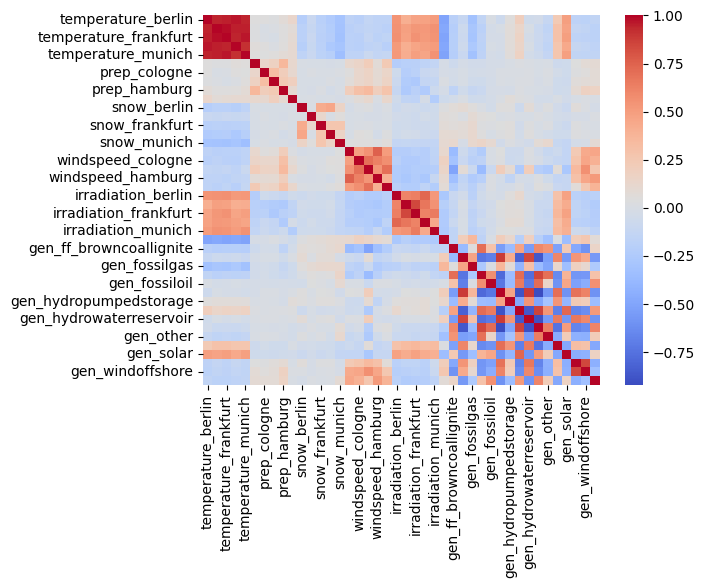

In [16]:
# First let's look at the correlation of all the features
sns.heatmap(X.corr(), cmap='coolwarm')

Takeaways: there are two distinct splits of data between weather metrics and power generation.

1. Weather features for given cities are highly correlated with eachother, such as temperature and irradiaton, but precipitation and snowfall are less so. Temperature and irraditiation are also correlated with eachother for a given city, which makes sense (if it's sunny, the temperature is higher, and vice-versa).
2. There are some high correlations among generation technologies too.
2. Let's split our features into two: weather and generation, remove some colinearity in those two cuts, and then consider the dataframe as a whole.

### Weather features

<Axes: >

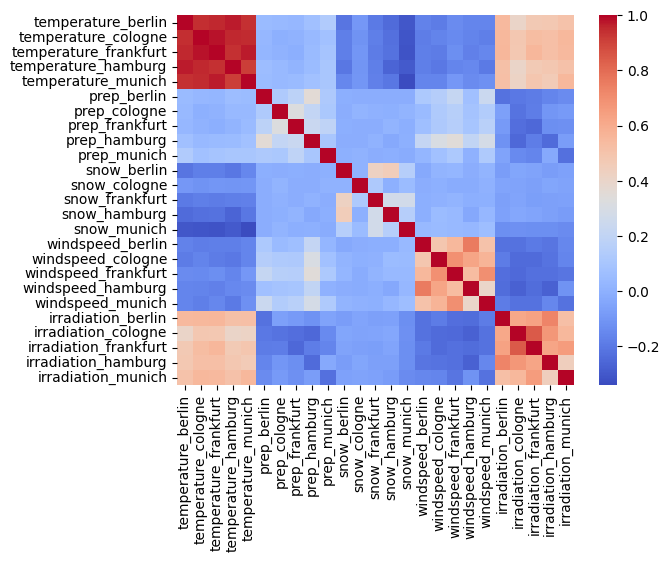

In [17]:
sns.heatmap(pd.DataFrame(X).iloc[:, 0: 25].corr(), cmap='coolwarm')

Conclusion: let's make a single feature for temperature, irradiation, and windspeed, and look at the matrix again. It will be the mean across the cities we have selected.

In [18]:
def average_weather(df: pd.DataFrame, measures: List[str]) -> pd.DataFrame:
    for measure in measures:
        col = f"{measure}_germany"
        df[col] = df[
            [c for c in df.columns if measure in c]
        ].mean(axis=1)
        df.drop(columns=[
            c for c in df.columns if measure in c and "germany" not in c
        ], inplace=True)
        df.insert(0, col, df.pop(col))
    return df

In [19]:
X = average_weather(X, ["temperature", "irradiation", "windspeed"])

<Axes: >

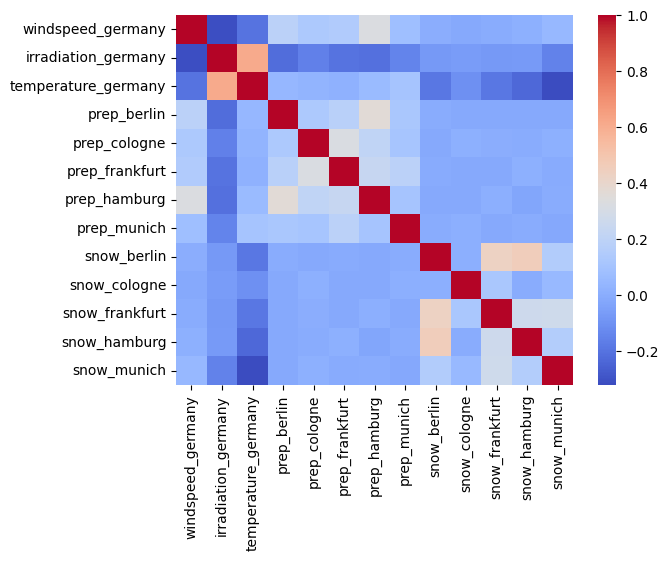

In [20]:
sns.heatmap(X.iloc[:, :13].corr(), cmap='coolwarm')

### Generation technologies correlation

<Axes: >

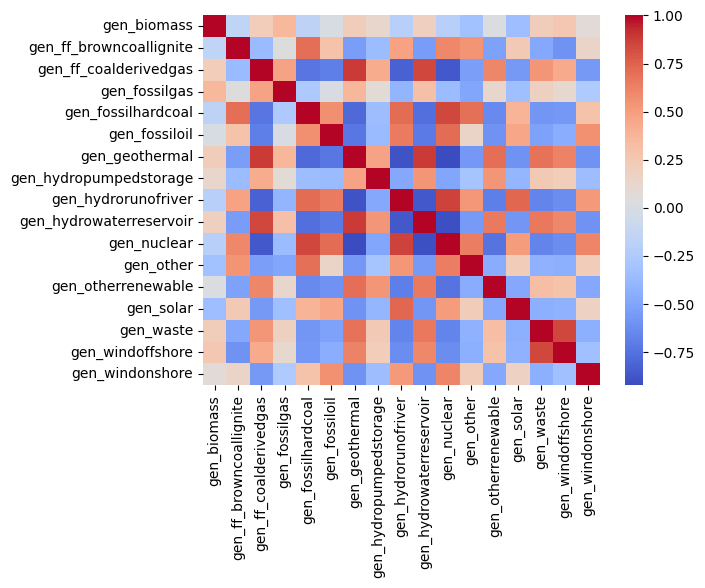

In [21]:
sns.heatmap(X.iloc[:, 13:].corr(), cmap='coolwarm')

Initially I thought about grouping some of these technologies (hydro, coal, gas, wind, etc.), but given the correlations between technologies aren't so obvious, I opted to leave them as is and let the PCA analysis make the decision.

## Scaling & PCA analysis

In order to run a PCA analysis, the data needs to be centered around the mean, so we use the StandardScaler() to scale the data.

In [22]:
X_features = list(X.columns)
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X_features)

In [23]:
pca = PCA()
pca.fit(X)

# Access our 30 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,index=X_features, columns=[f'PC{i}' for i in range(1, 31)])
W

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
windspeed_germany,0.040952,0.283452,-0.398037,-0.098887,0.269896,-0.184236,0.119600,-0.011765,-0.086826,-0.038230,...,0.228097,-0.211346,0.188962,0.044769,0.161539,0.337051,-0.059825,0.071798,0.332638,0.134428
irradiation_germany,-0.002698,-0.454823,0.029326,0.018043,0.296932,0.047252,0.051611,0.032577,-0.044578,0.151114,...,-0.214196,0.150726,0.064589,-0.037700,0.120284,-0.096540,0.046336,-0.235028,-0.081729,0.332542
temperature_germany,-0.012844,-0.442034,-0.226176,0.138504,0.105085,0.172226,-0.023151,0.057543,0.033082,-0.006996,...,0.366461,0.070196,0.383644,-0.048999,0.189073,-0.108813,0.014907,-0.046304,0.071676,0.042144
prep_berlin,0.003805,0.120249,-0.245508,0.200256,-0.123952,0.172471,-0.083865,0.093644,0.654411,-0.030011,...,-0.061398,0.026060,-0.003564,0.009795,-0.009287,-0.013245,-0.003157,-0.016577,-0.008686,-0.003935
prep_cologne,0.004176,0.101025,-0.193602,0.241942,-0.192169,0.254123,-0.022022,-0.018890,-0.411783,0.460822,...,-0.020224,0.003945,-0.013643,0.003315,-0.015064,-0.009587,0.011489,-0.007974,0.001722,0.002333
prep_frankfurt,0.007345,0.121409,-0.223011,0.260654,-0.212022,0.269277,-0.098995,-0.092072,-0.344127,0.166892,...,-0.017284,-0.015962,-0.005722,0.000869,0.011992,-0.000999,0.009678,-0.001566,0.005242,-0.006409
prep_hamburg,0.008071,0.145136,-0.339244,0.194227,-0.017671,0.116460,-0.052967,0.131246,0.385438,0.158228,...,-0.081359,0.021397,-0.005079,0.011689,0.000939,-0.000552,-0.010910,-0.002521,0.005958,0.003880
prep_munich,0.008006,0.032478,-0.148578,0.229910,-0.163205,0.243303,0.121768,-0.105920,-0.191510,-0.759480,...,-0.059957,0.059873,0.008518,-0.025024,0.015574,-0.034713,-0.001515,-0.020676,-0.011258,-0.018892
snow_berlin,0.015555,0.154187,0.205929,0.397766,0.373591,-0.007470,-0.128609,-0.071327,-0.001087,-0.089475,...,0.053906,-0.018418,-0.004120,0.018264,0.009760,-0.004800,-0.003102,0.010261,-0.012608,-0.008478
snow_cologne,-0.003451,0.069535,0.082358,-0.016532,-0.034476,0.134088,0.296223,0.827296,-0.169341,-0.128940,...,0.005007,0.012516,0.008622,-0.007682,-0.012051,-0.000215,0.000672,0.001216,0.000664,0.003912


<Axes: >

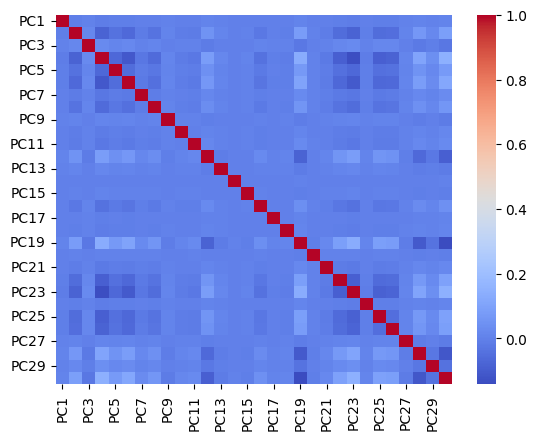

In [24]:
sns.heatmap(W.corr(), cmap='coolwarm')

In [25]:
pca.explained_variance_ratio_

array([0.30882458, 0.10706901, 0.08635407, 0.05535067, 0.05072113,
       0.04505949, 0.03601181, 0.03347193, 0.03206133, 0.03087184,
       0.02842724, 0.02395767, 0.02226883, 0.02200961, 0.02001316,
       0.01853998, 0.01579114, 0.01288149, 0.00978722, 0.00817704,
       0.00657539, 0.00547029, 0.00454968, 0.00379991, 0.00312225,
       0.00251754, 0.00212684, 0.00195838, 0.00145022, 0.00078025])

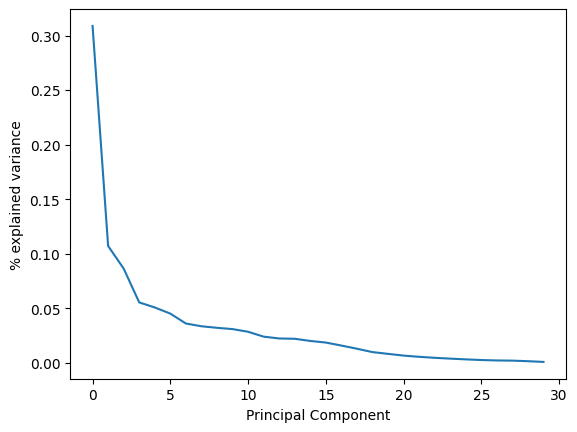

In [26]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

Almost 50% of the variance in the dataset can be explained in the first three axes.

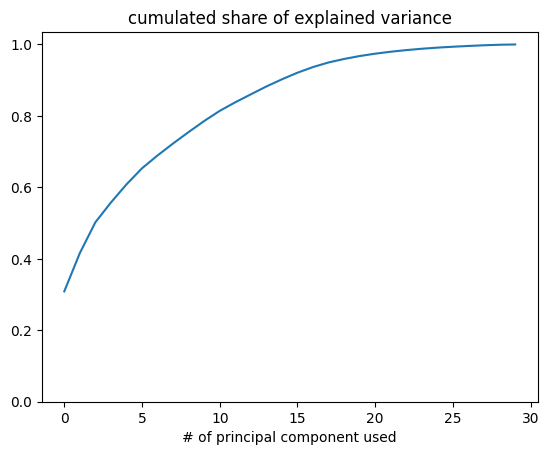

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [28]:
pca = PCA(n_components=25).fit(X) # Fit a PCA with  15 components
X_25 = pd.DataFrame(pca.fit_transform(X), columns=["PC" + str(i) for i in range(25)
]) # Project data into 25 dimensions
X_25

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,-2.198591,4.087311,-0.727306,1.665139,0.985556,-1.527229,4.461545,-0.191334,0.094967,2.409726,...,-0.004203,1.361191,-0.995782,1.115884,0.676399,-0.074147,0.320580,-0.786288,-0.172650,-0.143755
1,-2.869508,0.323930,0.415819,0.689918,-1.108582,-2.179567,0.388070,-0.084443,0.380952,-0.069338,...,-0.643820,-0.358314,-0.028174,0.169484,-0.531828,-0.462301,0.395645,-0.357737,-0.089075,-0.811885
2,-3.191639,0.487580,0.888783,0.735971,-1.638215,-2.451996,-0.408588,0.192471,-0.110009,0.072255,...,-0.446347,-0.305507,0.542338,0.548201,-0.498891,-0.417385,-0.106492,-0.255439,-0.067384,-0.588235
3,-2.978643,0.699651,0.673810,0.913246,-1.634788,-2.144362,0.683484,-0.277556,-0.128065,0.022113,...,-1.038012,-0.422481,-0.109048,-0.245648,-0.516750,-0.191977,0.350671,-0.000721,-0.041530,-0.501415
4,-2.964315,2.481151,-2.772033,2.400119,-2.027455,-0.311034,0.300432,-0.055735,0.333301,1.832392,...,-0.526393,-0.355080,0.223120,-0.397443,-0.487877,-0.604050,0.245038,-0.030287,0.042447,-0.144760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,3.284921,2.111110,-1.908627,1.819022,-2.578903,2.597868,-0.917740,-0.481998,-0.879326,-1.098599,...,0.506071,0.096230,-0.019802,-0.023503,-0.598309,0.159574,-0.420748,0.295052,0.669825,-0.448397
2037,4.506205,1.195666,-1.322272,-1.189814,1.026764,-1.894852,-0.722293,0.588247,-0.488636,-0.235754,...,-0.302139,0.053975,0.401502,0.586771,-0.272611,0.030645,0.594653,-0.646426,0.777769,-0.164646
2038,4.600307,2.038314,-2.841648,-0.855162,1.210786,-2.140491,-0.849447,0.873772,-0.250338,-0.059364,...,-0.399363,0.063659,0.375011,0.836247,-0.112312,0.355555,0.170996,-0.468195,0.676559,-0.185493
2039,4.534784,1.663045,-2.766412,-0.936917,1.351930,-2.031004,-0.796585,0.764454,-0.425794,-0.462641,...,-0.606313,-0.057446,0.412202,0.814339,-0.361479,0.992864,-0.462743,-0.050034,0.802610,-0.146199


In [29]:
# Test PCA data
X_train, X_test, y_train, y_test = train_test_split(X_25, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.6258914991262761

In [30]:
# Compared to no PCA analysis with all features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7243019414946974

Conclusion: I think let's ignore the option to reduce features with PCA analysis, and just use it to remove correlation between features.

# Build pipeline

To build pipeline:

1. fill null values for snow columns with 0 using SimpleImputer.
2. apply shifted() method to two other columns with null values using FunctionTransformer.
3. Average temperature, windspeed and irradiation with average_weather() method, using FunctionTransformer.
4. Scale all features for PCA analysis with StandardScaler.
5. Build in PCA analysis.
6. Add back in date column?

1. fill null values for snow columns with 0 using SimpleImputer.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
import pandas as pd 
pd.set_option('display.max_columns', None)

In [32]:
df.isna().sum()

date                       0
temperature_berlin         0
temperature_cologne        0
temperature_frankfurt      0
temperature_hamburg        0
temperature_munich         0
prep_berlin                0
prep_cologne               0
prep_frankfurt             0
prep_hamburg               0
prep_munich                0
snow_berlin                0
snow_cologne               0
snow_frankfurt             0
snow_hamburg               0
snow_munich                0
windspeed_berlin           0
windspeed_cologne          0
windspeed_frankfurt        0
windspeed_hamburg          0
windspeed_munich           0
irradiation_berlin         0
irradiation_cologne        0
irradiation_frankfurt      0
irradiation_hamburg        0
irradiation_munich         0
gen_biomass                0
gen_ff_browncoallignite    0
gen_ff_coalderivedgas      0
gen_fossilgas              0
gen_fossilhardcoal         0
gen_fossiloil              0
gen_geothermal             0
gen_hydropumpedstorage     0
gen_hydrorunof

In [33]:
df.head(5)

,date,temperature_berlin,temperature_cologne,temperature_frankfurt,temperature_hamburg,temperature_munich,prep_berlin,prep_cologne,prep_frankfurt,prep_hamburg,prep_munich,snow_berlin,snow_cologne,snow_frankfurt,snow_hamburg,snow_munich,windspeed_berlin,windspeed_cologne,windspeed_frankfurt,windspeed_hamburg,windspeed_munich,irradiation_berlin,irradiation_cologne,irradiation_frankfurt,irradiation_hamburg,irradiation_munich,gen_biomass,gen_ff_browncoallignite,gen_ff_coalderivedgas,gen_fossilgas,gen_fossilhardcoal,gen_fossiloil,gen_geothermal,gen_hydropumpedstorage,gen_hydrorunofriver,gen_hydrowaterreservoir,gen_nuclear,gen_other,gen_otherrenewable,gen_solar,gen_waste,gen_windoffshore,gen_windonshore,future_price
2780,2015-01-02,5.3,5.4,2.9,6.4,0.9,1.2,2.8,5.2,4.0,6.2,0.0,0.0,0.0,0.0,180.0,24.8,15.8,16.6,33.8,10.4,24.0,12.0,0.0,48.0,162.0,377636.0,1031133.0,0.0,119683.0,331933.0,17633.0,976.0,95042.0,104785.0,3514.0,874587.0,544964.0,10544.0,31036.0,46939.0,41791.0,2339633.0,36.09
2781,2015-01-05,3.3,2.4,2.2,3.9,1.7,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,5.4,6.5,14.0,9.4,0.0,378.0,438.0,0.0,156.0,377005.0,1615846.0,0.0,140177.0,693279.0,18054.0,1074.0,106871.0,150528.0,2110.0,1067486.0,769456.0,11801.0,106089.0,50310.0,31831.0,937875.0,35.26
2782,2015-01-06,0.9,1.7,-1.7,3.0,2.4,0.0,1.8,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.8,4.7,15.5,7.9,0.0,120.0,0.0,0.0,342.0,375664.0,1695451.0,0.0,170726.0,1038056.0,18006.0,1131.0,72249.0,141245.0,3443.0,1095042.0,813812.0,11850.0,131549.0,53909.0,27274.0,421371.0,34.65
2783,2015-01-07,2.1,4.4,2.2,4.4,1.9,0.4,3.2,0.3,0.1,1.1,0.0,0.0,0.0,0.0,0.0,11.9,10.1,10.1,17.3,10.1,18.0,162.0,108.0,204.0,0.0,379278.0,1728747.0,0.0,225577.0,1041638.0,19617.0,1095.0,128841.0,138109.0,3709.0,1098462.0,840672.0,11970.0,68459.0,53907.0,43081.0,897230.0,34.39
2784,2015-01-08,3.5,5.8,5.8,5.1,5.5,9.6,18.4,7.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,17.3,15.8,16.2,23.8,12.2,0.0,0.0,0.0,0.0,0.0,377018.0,1603640.0,0.0,154864.0,899441.0,20430.0,1070.0,102712.0,138667.0,4802.0,1089419.0,694632.0,11037.0,34393.0,58989.0,49796.0,1721345.0,33.98


In [34]:
df.shape

(2041, 44)

In [35]:
X = df.drop(columns='future_price')
y = df['future_price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1632, 43), (409, 43), (1632,), (409,))

In [36]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('standard_scaler', StandardScaler()), 
])

pipeline.fit(X_train[['date']])
pipeline.transform(X_train[['date']])

array([[-0.90370053],
       [ 0.10030183],
       [-0.66363871],
       ...,
       [-0.3313364 ],
       [ 1.34673115],
       [ 1.56668926]])

In [37]:
pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standard_scaler', StandardScaler())])

In [38]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('standard_scaler', StandardScaler())
])

In [39]:
from sklearn import set_config; set_config(display='diagram')

2. apply shifted() method to two other columns with null values using FunctionTransformer.

In [40]:
#apply shifted() method to two other columns with null values using FunctionTransformer.
import numpy as np
from sklearn.preprocessing import FunctionTransformer 
def shifted_method(prep_berlin, shift_value=0):
    shifted_prep_berlin=shift_prep_berlin, shift_value=0
    return shifted_prep_berlin 
shift_value=0

#transformer=FunctionTransformer (func=shifted_method, kw=args={'shift_value'})    
    
#prep_berlin_imputer = SimpleImputer(strategy="constant", fill_value=0)
#prep_cologne_imputer = SimpleImputer(strategy="constant", fill_value=0)

3. Average temperature, windspeed and irradiation with average_weather() method, using FunctionTransformer.

In [100]:
df

,temperature_berlin,temperature_cologne,temperature_frankfurt,temperature_hamburg,temperature_munich,prep_berlin,prep_cologne,prep_frankfurt,prep_hamburg,prep_munich,snow_berlin,snow_cologne,snow_frankfurt,snow_hamburg,snow_munich,windspeed_berlin,windspeed_cologne,windspeed_frankfurt,windspeed_hamburg,windspeed_munich,irradiation_berlin,irradiation_cologne,irradiation_frankfurt,irradiation_hamburg,irradiation_munich,gen_biomass,gen_ff_browncoallignite,gen_ff_coalderivedgas,gen_fossilgas,gen_fossilhardcoal,gen_fossiloil,gen_geothermal,gen_hydropumpedstorage,gen_hydrorunofriver,gen_hydrowaterreservoir,gen_nuclear,gen_other,gen_otherrenewable,gen_solar,gen_waste,gen_windoffshore,gen_windonshore,future_price
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,5.3,5.4,2.9,6.4,0.9,1.2,2.8,5.2,4.0,6.2,0.0,0.0,0.0,0.0,180.0,24.8,15.8,16.6,33.8,10.4,24.0,12.0,0.0,48.0,162.0,377636.0,1031133.0,0.0,119683.0,331933.0,17633.0,976.0,95042.0,104785.0,3514.0,874587.0,544964.0,10544.0,31036.0,46939.0,41791.0,2339633.0,36.09
2015-01-05,3.3,2.4,2.2,3.9,1.7,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,5.4,6.5,14.0,9.4,0.0,378.0,438.0,0.0,156.0,377005.0,1615846.0,0.0,140177.0,693279.0,18054.0,1074.0,106871.0,150528.0,2110.0,1067486.0,769456.0,11801.0,106089.0,50310.0,31831.0,937875.0,35.26
2015-01-06,0.9,1.7,-1.7,3.0,2.4,0.0,1.8,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.8,4.7,15.5,7.9,0.0,120.0,0.0,0.0,342.0,375664.0,1695451.0,0.0,170726.0,1038056.0,18006.0,1131.0,72249.0,141245.0,3443.0,1095042.0,813812.0,11850.0,131549.0,53909.0,27274.0,421371.0,34.65
2015-01-07,2.1,4.4,2.2,4.4,1.9,0.4,3.2,0.3,0.1,1.1,0.0,0.0,0.0,0.0,0.0,11.9,10.1,10.1,17.3,10.1,18.0,162.0,108.0,204.0,0.0,379278.0,1728747.0,0.0,225577.0,1041638.0,19617.0,1095.0,128841.0,138109.0,3709.0,1098462.0,840672.0,11970.0,68459.0,53907.0,43081.0,897230.0,34.39
2015-01-08,3.5,5.8,5.8,5.1,5.5,9.6,18.4,7.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,17.3,15.8,16.2,23.8,12.2,0.0,0.0,0.0,0.0,0.0,377018.0,1603640.0,0.0,154864.0,899441.0,20430.0,1070.0,102712.0,138667.0,4802.0,1089419.0,694632.0,11037.0,34393.0,58989.0,49796.0,1721345.0,33.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,5.0,10.2,10.2,5.8,10.5,9.9,8.0,17.9,3.9,18.4,0.0,0.0,0.0,0.0,0.0,8.6,16.5,13.1,7.2,16.9,0.0,0.0,0.0,0.0,2.0,459329.0,1222282.0,588743.0,691254.0,768.0,2584.0,167010.0,129685.0,4305.0,343918.0,33176.0,14663.0,49254.0,76316.0,149503.0,1127734.0,0.0,210.97
2022-12-27,4.2,5.9,4.6,4.3,4.5,0.0,0.0,0.0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,18.6,15.5,13.7,19.8,9.7,6.0,162.0,361.0,167.0,333.0,451244.0,625075.0,272233.0,408720.0,768.0,2779.0,172519.0,136913.0,7316.0,341602.0,20871.0,10552.0,203444.0,76261.0,550267.0,2253498.0,0.0,212.92
2022-12-28,5.2,9.3,7.4,7.2,5.1,1.5,2.9,0.1,7.7,0.0,0.0,0.0,0.0,0.0,0.0,19.1,20.0,19.2,27.7,9.4,0.0,0.0,0.0,0.0,216.0,449759.0,480219.0,257363.0,280191.0,768.0,2364.0,142892.0,133731.0,6930.0,339315.0,20853.0,10527.0,128054.0,53543.0,569335.0,2776447.0,0.0,201.97


In [103]:
df1 = df[['temperature_berlin', 'temperature_cologne', 'temperature_frankfurt', 'temperature_hamburg', 'temperature_munich']]
df1=pd.DataFrame(df1.apply(np.mean, axis=1), columns=['temperature'])
#df1.apply(np.mean, axis=1)
#pd.DataFrame(df1.apply(np.mean, axis=1))

In [104]:
df1

,temperature
date,
2015-01-02,4.18
2015-01-05,2.70
2015-01-06,1.26
2015-01-07,3.00
2015-01-08,5.14
...,...
2022-12-23,8.34
2022-12-27,4.70
2022-12-28,6.84


In [105]:
df2 = df[['windspeed_berlin', 'windspeed_cologne', 'windspeed_frankfurt', 'windspeed_hamburg', 'windspeed_munich']]
df2=pd.DataFrame(df2.apply(np.mean, axis=1), columns=['windspeed'])

In [106]:
df2

,windspeed
date,
2015-01-02,20.28
2015-01-05,11.16
2015-01-06,10.38
2015-01-07,11.90
2015-01-08,17.06
...,...
2022-12-23,12.46
2022-12-27,15.46
2022-12-28,19.08


In [107]:
df3 = df[['irradiation_berlin', 'irradiation_cologne', 'irradiation_frankfurt', 'irradiation_hamburg', 'irradiation_munich']]
df3=pd.DataFrame(df3.apply(np.mean, axis=1), columns=['irradiation'])

In [108]:
df3

,irradiation
date,
2015-01-02,49.2
2015-01-05,194.4
2015-01-06,92.4
2015-01-07,98.4
2015-01-08,0.0
...,...
2022-12-23,0.4
2022-12-27,205.8
2022-12-28,43.2


In [109]:
df4=df[['future_price']]
df4.apply(np.mean, axis=1)

date
2015-01-02     36.09
2015-01-05     35.26
2015-01-06     34.65
2015-01-07     34.39
2015-01-08     33.98
               ...  
2022-12-23    210.97
2022-12-27    212.92
2022-12-28    201.97
2022-12-29    194.34
2022-12-30    167.00
Length: 2041, dtype: float64

In [110]:
df4

,future_price
date,
2015-01-02,36.09
2015-01-05,35.26
2015-01-06,34.65
2015-01-07,34.39
2015-01-08,33.98
...,...
2022-12-23,210.97
2022-12-27,212.92
2022-12-28,201.97


In [55]:
df1.corrwith(df4, axis = 1)

2780   NaN
2781   NaN
2782   NaN
2783   NaN
2784   NaN
        ..
4816   NaN
4817   NaN
4818   NaN
4819   NaN
4820   NaN
Length: 2041, dtype: float64

In [56]:
df2.corrwith(df4, axis = 1)

2780   NaN
2781   NaN
2782   NaN
2783   NaN
2784   NaN
        ..
4816   NaN
4817   NaN
4818   NaN
4819   NaN
4820   NaN
Length: 2041, dtype: float64

In [57]:
df.set_index('date')

,temperature_berlin,temperature_cologne,temperature_frankfurt,temperature_hamburg,temperature_munich,prep_berlin,prep_cologne,prep_frankfurt,prep_hamburg,prep_munich,snow_berlin,snow_cologne,snow_frankfurt,snow_hamburg,snow_munich,windspeed_berlin,windspeed_cologne,windspeed_frankfurt,windspeed_hamburg,windspeed_munich,irradiation_berlin,irradiation_cologne,irradiation_frankfurt,irradiation_hamburg,irradiation_munich,gen_biomass,gen_ff_browncoallignite,gen_ff_coalderivedgas,gen_fossilgas,gen_fossilhardcoal,gen_fossiloil,gen_geothermal,gen_hydropumpedstorage,gen_hydrorunofriver,gen_hydrowaterreservoir,gen_nuclear,gen_other,gen_otherrenewable,gen_solar,gen_waste,gen_windoffshore,gen_windonshore,future_price
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,5.3,5.4,2.9,6.4,0.9,1.2,2.8,5.2,4.0,6.2,0.0,0.0,0.0,0.0,180.0,24.8,15.8,16.6,33.8,10.4,24.0,12.0,0.0,48.0,162.0,377636.0,1031133.0,0.0,119683.0,331933.0,17633.0,976.0,95042.0,104785.0,3514.0,874587.0,544964.0,10544.0,31036.0,46939.0,41791.0,2339633.0,36.09
2015-01-05,3.3,2.4,2.2,3.9,1.7,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,5.4,6.5,14.0,9.4,0.0,378.0,438.0,0.0,156.0,377005.0,1615846.0,0.0,140177.0,693279.0,18054.0,1074.0,106871.0,150528.0,2110.0,1067486.0,769456.0,11801.0,106089.0,50310.0,31831.0,937875.0,35.26
2015-01-06,0.9,1.7,-1.7,3.0,2.4,0.0,1.8,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.8,4.7,15.5,7.9,0.0,120.0,0.0,0.0,342.0,375664.0,1695451.0,0.0,170726.0,1038056.0,18006.0,1131.0,72249.0,141245.0,3443.0,1095042.0,813812.0,11850.0,131549.0,53909.0,27274.0,421371.0,34.65
2015-01-07,2.1,4.4,2.2,4.4,1.9,0.4,3.2,0.3,0.1,1.1,0.0,0.0,0.0,0.0,0.0,11.9,10.1,10.1,17.3,10.1,18.0,162.0,108.0,204.0,0.0,379278.0,1728747.0,0.0,225577.0,1041638.0,19617.0,1095.0,128841.0,138109.0,3709.0,1098462.0,840672.0,11970.0,68459.0,53907.0,43081.0,897230.0,34.39
2015-01-08,3.5,5.8,5.8,5.1,5.5,9.6,18.4,7.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,17.3,15.8,16.2,23.8,12.2,0.0,0.0,0.0,0.0,0.0,377018.0,1603640.0,0.0,154864.0,899441.0,20430.0,1070.0,102712.0,138667.0,4802.0,1089419.0,694632.0,11037.0,34393.0,58989.0,49796.0,1721345.0,33.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,5.0,10.2,10.2,5.8,10.5,9.9,8.0,17.9,3.9,18.4,0.0,0.0,0.0,0.0,0.0,8.6,16.5,13.1,7.2,16.9,0.0,0.0,0.0,0.0,2.0,459329.0,1222282.0,588743.0,691254.0,768.0,2584.0,167010.0,129685.0,4305.0,343918.0,33176.0,14663.0,49254.0,76316.0,149503.0,1127734.0,0.0,210.97
2022-12-27,4.2,5.9,4.6,4.3,4.5,0.0,0.0,0.0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,18.6,15.5,13.7,19.8,9.7,6.0,162.0,361.0,167.0,333.0,451244.0,625075.0,272233.0,408720.0,768.0,2779.0,172519.0,136913.0,7316.0,341602.0,20871.0,10552.0,203444.0,76261.0,550267.0,2253498.0,0.0,212.92
2022-12-28,5.2,9.3,7.4,7.2,5.1,1.5,2.9,0.1,7.7,0.0,0.0,0.0,0.0,0.0,0.0,19.1,20.0,19.2,27.7,9.4,0.0,0.0,0.0,0.0,216.0,449759.0,480219.0,257363.0,280191.0,768.0,2364.0,142892.0,133731.0,6930.0,339315.0,20853.0,10527.0,128054.0,53543.0,569335.0,2776447.0,0.0,201.97


In [58]:
#Scale all features for PCA analysis with StandardScaler
scaler = StandardScaler()
df=df.set_index('date')
scaler.fit(df)
scaled_df = scaler.transform(df)
pca = PCA()
principal_components = pca.fit_transform(scaled_df)

In [59]:
#Build in PCA analysis
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df)
transformed_data = pca.transform(df)

In [60]:
'''#fit pipeline to the training set 
pipeline.fit(X_train)
#tranform both the training set and the test set 
X_train_transformed = pd.DataFrame(pipeline.transform(X_train))
X_train_transformed
X_test_transformed = pd.DataFrame(pipeline.transform(X_test))
X_test_transformed
#standardize X-test and x_train 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
'''

'#fit pipeline to the training set \npipeline.fit(X_train)\n#tranform both the training set and the test set \nX_train_transformed = pd.DataFrame(pipeline.transform(X_train))\nX_train_transformed\nX_test_transformed = pd.DataFrame(pipeline.transform(X_test))\nX_test_transformed\n#standardize X-test and x_train \nscaler = StandardScaler()\nscaler.fit(X_train)\nX_train_scaled = scaler.transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n'

In [61]:
snow_imputer = SimpleImputer(strategy="constant", fill_value=0)

In [62]:
preprocessor = ColumnTransformer([
    ("snow_transformer", snow_imputer, [col for col in df.columns if "snow" in col]),
],
    remainder="passthrough",)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('snow_transformer',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['snow_berlin', 'snow_cologne',
                                  'snow_frankfurt', 'snow_hamburg',
                                  'snow_munich'])])

In [64]:
#preprocessor.get_feature_names_out()

In [68]:
'''preprocessor = ColumnTransformer([
    ("prep_berlin_transformer", prep_berlin_imputer, [col for col in df.columns if "prep_berlin" in col]),
], remainder="passthrough",)
    ("prep_cologne_transformer", prep_cologne_imputer, [col for col in df.columns if "prep_cologne" in col]),
], remainder="passthrough",)
preprocessor>'''

'preprocessor = ColumnTransformer([\n    ("prep_berlin_transformer", prep_berlin_imputer, [col for col in df.columns if "prep_berlin" in col]),\n], remainder="passthrough",)\n    ("prep_cologne_transformer", prep_cologne_imputer, [col for col in df.columns if "prep_cologne" in col]),\n], remainder="passthrough",)\npreprocessor>'

In [69]:
df1

,temperature
2780,4.18
2781,2.70
2782,1.26
2783,3.00
2784,5.14
...,...
4816,8.34
4817,4.70
4818,6.84
4819,9.76


In [70]:
#join all them together 
unified_frame = df1.join(df2['windspeed']).join(df3['irradiation']).join(df4['future_price'])
unified_frame

,temperature,windspeed,irradiation,future_price
2780,4.18,20.28,49.2,36.09
2781,2.70,11.16,194.4,35.26
2782,1.26,10.38,92.4,34.65
2783,3.00,11.90,98.4,34.39
2784,5.14,17.06,0.0,33.98
...,...,...,...,...
4816,8.34,12.46,0.4,210.97
4817,4.70,15.46,205.8,212.92
4818,6.84,19.08,43.2,201.97
4819,9.76,20.64,70.0,194.34


In [71]:
# correlation between all columns
unified_frame.corr()
# correlation between two columns
#unified_frame['average_temp'].corr(unified_frame['co'])

,temperature,windspeed,irradiation,future_price
temperature,1.000000,-0.200699,0.610886,0.046904
windspeed,-0.200699,1.000000,-0.313046,-0.050583
irradiation,0.610886,-0.313046,1.000000,0.030872
future_price,0.046904,-0.050583,0.030872,1.000000


In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# define a dummy function as an example
def my_func(X=df, factor=100): # in the definition of the function we set the desired values for arguments
    X['new_col'] = X['cost'] * factor
    return X

# create a variable that would store FunctionTransformer applied to our function
my_func_transformer = FunctionTransformer(my_func)

# put that variable into the pipeline
preprocessor = Pipeline(steps=[
  ('my_func', my_func_transformer),
  # ... any other transformers we want to include, e.g. SimpleImputer or MinMaxScaler
])

# see the transformation
frame_transformed = preprocessor.fit_transform(df)
frame_transformed

KeyError: 'cost'

# Data visualisation 

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
#df_new = df[['Ref_Date', 'future_price']]
#print(df_new)

In [80]:
df

,temperature_berlin,temperature_cologne,temperature_frankfurt,temperature_hamburg,temperature_munich,prep_berlin,prep_cologne,prep_frankfurt,prep_hamburg,prep_munich,snow_berlin,snow_cologne,snow_frankfurt,snow_hamburg,snow_munich,windspeed_berlin,windspeed_cologne,windspeed_frankfurt,windspeed_hamburg,windspeed_munich,irradiation_berlin,irradiation_cologne,irradiation_frankfurt,irradiation_hamburg,irradiation_munich,gen_biomass,gen_ff_browncoallignite,gen_ff_coalderivedgas,gen_fossilgas,gen_fossilhardcoal,gen_fossiloil,gen_geothermal,gen_hydropumpedstorage,gen_hydrorunofriver,gen_hydrowaterreservoir,gen_nuclear,gen_other,gen_otherrenewable,gen_solar,gen_waste,gen_windoffshore,gen_windonshore,future_price
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,5.3,5.4,2.9,6.4,0.9,1.2,2.8,5.2,4.0,6.2,0.0,0.0,0.0,0.0,180.0,24.8,15.8,16.6,33.8,10.4,24.0,12.0,0.0,48.0,162.0,377636.0,1031133.0,0.0,119683.0,331933.0,17633.0,976.0,95042.0,104785.0,3514.0,874587.0,544964.0,10544.0,31036.0,46939.0,41791.0,2339633.0,36.09
2015-01-05,3.3,2.4,2.2,3.9,1.7,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.5,5.4,6.5,14.0,9.4,0.0,378.0,438.0,0.0,156.0,377005.0,1615846.0,0.0,140177.0,693279.0,18054.0,1074.0,106871.0,150528.0,2110.0,1067486.0,769456.0,11801.0,106089.0,50310.0,31831.0,937875.0,35.26
2015-01-06,0.9,1.7,-1.7,3.0,2.4,0.0,1.8,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.8,4.7,15.5,7.9,0.0,120.0,0.0,0.0,342.0,375664.0,1695451.0,0.0,170726.0,1038056.0,18006.0,1131.0,72249.0,141245.0,3443.0,1095042.0,813812.0,11850.0,131549.0,53909.0,27274.0,421371.0,34.65
2015-01-07,2.1,4.4,2.2,4.4,1.9,0.4,3.2,0.3,0.1,1.1,0.0,0.0,0.0,0.0,0.0,11.9,10.1,10.1,17.3,10.1,18.0,162.0,108.0,204.0,0.0,379278.0,1728747.0,0.0,225577.0,1041638.0,19617.0,1095.0,128841.0,138109.0,3709.0,1098462.0,840672.0,11970.0,68459.0,53907.0,43081.0,897230.0,34.39
2015-01-08,3.5,5.8,5.8,5.1,5.5,9.6,18.4,7.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,17.3,15.8,16.2,23.8,12.2,0.0,0.0,0.0,0.0,0.0,377018.0,1603640.0,0.0,154864.0,899441.0,20430.0,1070.0,102712.0,138667.0,4802.0,1089419.0,694632.0,11037.0,34393.0,58989.0,49796.0,1721345.0,33.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,5.0,10.2,10.2,5.8,10.5,9.9,8.0,17.9,3.9,18.4,0.0,0.0,0.0,0.0,0.0,8.6,16.5,13.1,7.2,16.9,0.0,0.0,0.0,0.0,2.0,459329.0,1222282.0,588743.0,691254.0,768.0,2584.0,167010.0,129685.0,4305.0,343918.0,33176.0,14663.0,49254.0,76316.0,149503.0,1127734.0,0.0,210.97
2022-12-27,4.2,5.9,4.6,4.3,4.5,0.0,0.0,0.0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,18.6,15.5,13.7,19.8,9.7,6.0,162.0,361.0,167.0,333.0,451244.0,625075.0,272233.0,408720.0,768.0,2779.0,172519.0,136913.0,7316.0,341602.0,20871.0,10552.0,203444.0,76261.0,550267.0,2253498.0,0.0,212.92
2022-12-28,5.2,9.3,7.4,7.2,5.1,1.5,2.9,0.1,7.7,0.0,0.0,0.0,0.0,0.0,0.0,19.1,20.0,19.2,27.7,9.4,0.0,0.0,0.0,0.0,216.0,449759.0,480219.0,257363.0,280191.0,768.0,2364.0,142892.0,133731.0,6930.0,339315.0,20853.0,10527.0,128054.0,53543.0,569335.0,2776447.0,0.0,201.97


In [83]:
df.future_price

date
2015-01-02     36.09
2015-01-05     35.26
2015-01-06     34.65
2015-01-07     34.39
2015-01-08     33.98
               ...  
2022-12-23    210.97
2022-12-27    212.92
2022-12-28    201.97
2022-12-29    194.34
2022-12-30    167.00
Name: future_price, Length: 2041, dtype: float64

In [97]:
df.df1

AttributeError: 'DataFrame' object has no attribute 'df1'

<Axes: xlabel='date'>

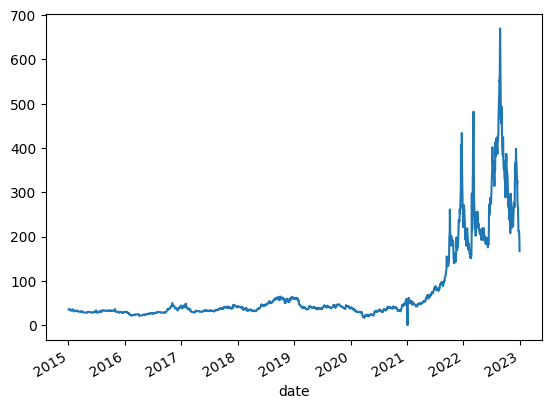

In [86]:
df.future_price.plot()

Text(0.5, 1.0, 'variations of electricity prices in Germany')

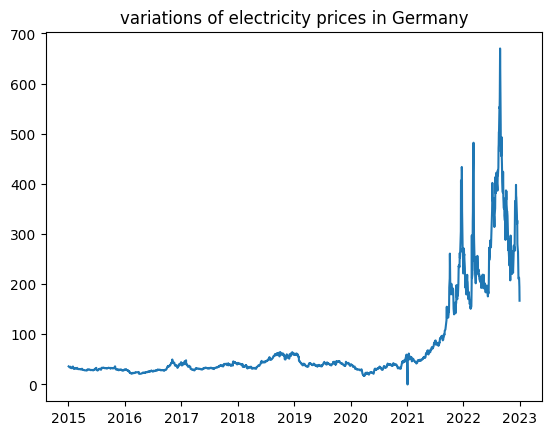

In [91]:
plt.plot(df.future_price)
plt.title("variations of electricity prices in Germany")

Text(0.5, 1.0, 'variations of electricity prices in Germany')

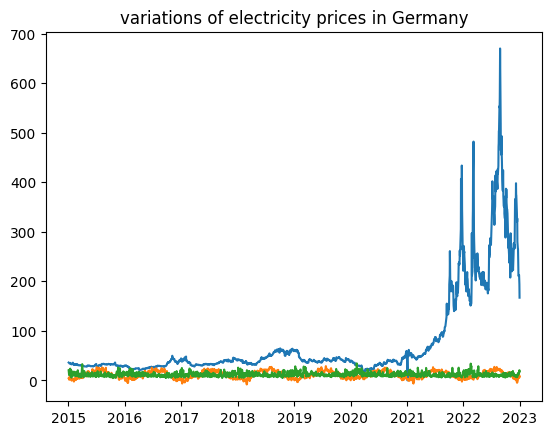

In [111]:
plt.plot(df.future_price)
plt.plot(df1.temperature)
plt.plot(df2.windspeed)
plt.title("variations of electricity prices in Germany")

In [95]:
df.corr().style.background_gradient(cmap="Blues")

,temperature_berlin,temperature_cologne,temperature_frankfurt,temperature_hamburg,temperature_munich,prep_berlin,prep_cologne,prep_frankfurt,prep_hamburg,prep_munich,snow_berlin,snow_cologne,snow_frankfurt,snow_hamburg,snow_munich,windspeed_berlin,windspeed_cologne,windspeed_frankfurt,windspeed_hamburg,windspeed_munich,irradiation_berlin,irradiation_cologne,irradiation_frankfurt,irradiation_hamburg,irradiation_munich,gen_biomass,gen_ff_browncoallignite,gen_ff_coalderivedgas,gen_fossilgas,gen_fossilhardcoal,gen_fossiloil,gen_geothermal,gen_hydropumpedstorage,gen_hydrorunofriver,gen_hydrowaterreservoir,gen_nuclear,gen_other,gen_otherrenewable,gen_solar,gen_waste,gen_windoffshore,gen_windonshore,future_price
temperature_berlin,1.000000,0.945321,0.954611,0.969771,0.940118,0.044396,0.042143,0.028045,0.070827,0.134295,-0.210595,-0.099130,-0.197872,-0.243474,-0.304314,-0.170786,-0.193355,-0.137383,-0.161171,-0.159185,0.546858,0.407127,0.473881,0.478599,0.507813,-0.508117,-0.186199,-0.112153,-0.315807,-0.142758,-0.000067,-0.066996,0.048570,0.202831,-0.053950,-0.048757,-0.115457,0.237815,0.491052,-0.168659,-0.177224,-0.143423,0.014860
temperature_cologne,0.945321,1.000000,0.982208,0.953223,0.948517,0.029247,-0.001360,0.009649,0.040782,0.074803,-0.179293,-0.111003,-0.182157,-0.227769,-0.310826,-0.187204,-0.165818,-0.143812,-0.163220,-0.182824,0.554116,0.484142,0.532176,0.522643,0.553314,-0.480685,-0.213819,-0.074758,-0.284373,-0.180944,-0.029195,-0.011433,0.062327,0.138973,-0.012729,-0.095803,-0.150545,0.292457,0.468372,-0.129830,-0.143346,-0.177196,0.065494
temperature_frankfurt,0.954611,0.982208,1.000000,0.941602,0.969569,0.025930,0.005982,-0.006143,0.044779,0.091165,-0.182681,-0.101549,-0.191676,-0.220777,-0.314915,-0.182555,-0.188204,-0.125975,-0.176572,-0.154560,0.559820,0.478976,0.555395,0.519252,0.549320,-0.503751,-0.202865,-0.085573,-0.298204,-0.164310,-0.021507,-0.027678,0.062967,0.161098,-0.032817,-0.081720,-0.138826,0.288350,0.490199,-0.158318,-0.168981,-0.172978,0.055552
temperature_hamburg,0.969771,0.953223,0.941602,1.000000,0.913489,0.056391,0.040156,0.014676,0.049878,0.102969,-0.206113,-0.104431,-0.180529,-0.264446,-0.295795,-0.182117,-0.199268,-0.157741,-0.146512,-0.197853,0.515405,0.407478,0.466376,0.482917,0.509734,-0.489573,-0.206450,-0.072924,-0.266080,-0.177760,-0.010385,-0.021424,0.063564,0.147161,-0.009659,-0.090971,-0.152486,0.264438,0.444481,-0.116878,-0.140767,-0.162908,0.056478
temperature_munich,0.940118,0.948517,0.969569,0.913489,1.000000,0.047573,0.037259,0.047111,0.077871,0.101393,-0.156460,-0.099407,-0.176043,-0.205443,-0.339932,-0.157225,-0.160429,-0.094187,-0.138741,-0.124107,0.520233,0.416111,0.491650,0.464207,0.551655,-0.510297,-0.210971,-0.098022,-0.319431,-0.168516,-0.022072,-0.036123,0.057279,0.168574,-0.041965,-0.069413,-0.127392,0.264716,0.482180,-0.143438,-0.151457,-0.144553,0.040710
prep_berlin,0.044396,0.029247,0.025930,0.056391,0.047573,1.000000,0.130773,0.179103,0.361367,0.120717,-0.004977,-0.011282,-0.013119,-0.013676,-0.011612,0.117042,0.151098,0.216390,0.071029,0.239258,-0.220618,-0.200917,-0.193174,-0.159639,-0.138265,-0.013612,-0.072285,-0.027286,-0.049922,-0.045251,-0.021270,-0.022162,0.001226,0.021790,0.006929,-0.008398,-0.002924,-0.066604,-0.061935,0.036557,0.083916,0.086594,-0.014574
prep_cologne,0.042143,-0.001360,0.005982,0.040156,0.037259,0.130773,1.000000,0.323161,0.207751,0.112256,-0.012222,0.012399,0.001149,-0.002735,0.010787,0.042500,0.127203,0.159737,0.087345,0.137473,-0.062615,-0.215635,-0.185485,-0.102329,-0.087952,-0.019301,-0.034457,-0.009885,-0.039704,-0.032212,-0.021182,0.005493,0.006439,0.006444,0.014885,-0.010638,0.010903,-0.039554,-0.060328,0.028420,0.046863,0.079207,-0.012473
prep_frankfurt,0.028045,0.009649,-0.006143,0.014676,0.047111,0.179103,0.323161,1.000000,0.234764,0.190037,-0.006208,-0.010787,-0.012223,0.014634,-0.009019,0.065151,0.124149,0.154916,0.094703,0.162552,-0.084135,-0.234813,-0.253934,-0.127911,-0.124934,0.010321,-0.042094,-0.008714,-0.054212,-0.05

Text(0.5, 1.0, 'variations of electricity prices in Germany')

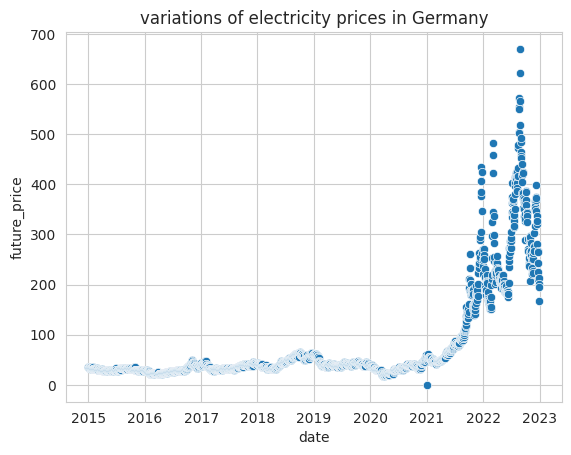

In [114]:
with sns.axes_style('whitegrid'): 
    # sns.set(style="whitegrid") for global change
    sns.scatterplot(x="date", y="future_price", data=df);
plt.title("variations of electricity prices in Germany")

/tmp/ipykernel_27141/2371613101.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="date", y="future_price",


<Axes: xlabel='date', ylabel='future_price'>

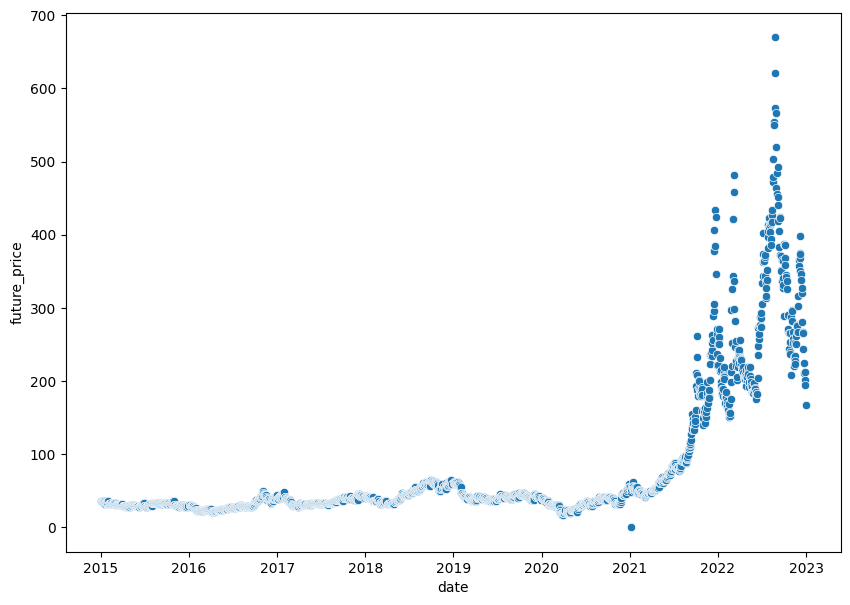

In [119]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x="date", y="future_price",
                palette=sns.color_palette(["#2ecc71", "#e74c3c"]),
                sizes=(10, 300), data=df)

In [92]:
plt.figure(figsize=(10,5))

# 3 lines plot
plt.plot(date_x, future_price_y, label='total', c="grey", ls=':', marker='s')
plt.plot(df1, label='temperature')
plt.plot(df2, label='windspeed')
plt.plot(df3, label='irradiation')
# Decoration
plt.legend()
plt.title('German electricity price')
plt.ylim((0,700))
plt.ylabel('Price')
plt.grid(lw=0.5)

plt.show()

NameError: name 'date_x' is not defined

<Figure size 1000x500 with 0 Axes>

# Appendix: Charting

In [ ]:
def plot_weather_patterns(city: str):

    temp = [col for col in df.columns if city in col and "temperature" in col]
    prep = [col for col in df.columns if city in col and "prep" in col]
    wind = [col for col in df.columns if city in col and "windspeed" in col]
    snow = [col for col in df.columns if city in col and "snow" in col]
    irr = [col for col in df.columns if city in col and "irradiation" in col]

    # Start figure
    plt.figure(figsize=(10,15))

    # Temperature
    plt.subplot(5, 1, 1)
    plt.plot(df.date, df[temp], c="black", linewidth=0.5)
    plt.title("Average temperature")
    # Precipitation
    plt.subplot(5, 1, 2)
    plt.plot(df.date, df[prep], c='black', linewidth=0.5)
    plt.title("Precipitation")
    # Wind speed
    plt.subplot(5, 1, 3)
    plt.plot(df.date, df[wind], c='black', linewidth=0.5)
    plt.title("Wind speed")
    # Snow fall
    plt.subplot(5, 1, 4)
    plt.plot(df.date, df[snow], c='black', linewidth=0.5)
    plt.title("Snow")
    # Solar irradiation
    plt.subplot(5, 1, 5)
    plt.plot(df.date, df[irr], c='black', linewidth=0.5)
    plt.title("Solar irradiation")
    
    plt.show();

In [ ]:
plot_weather_patterns("munich")